In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

(371, 557, 371)


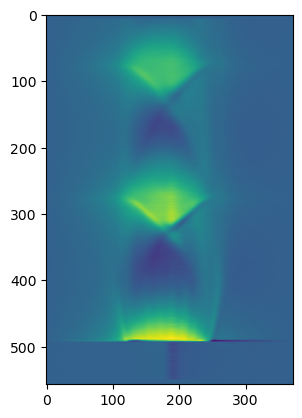

In [9]:
frames = np.load("density_2410.npy",allow_pickle=True)
frames=np.rot90(frames,1)
print(frames.shape)
plt.imshow(frames[170])

# animation

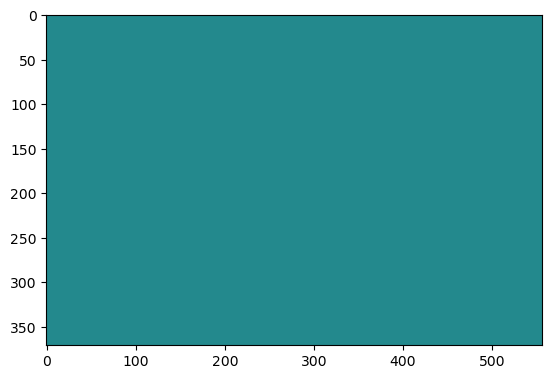

In [10]:
#描画の初期化
fig, ax = plt.subplots()
img = ax.imshow(np.rot90(frames[0,:,:]),vmin=0,vmax=2.5)

# アニメーションの更新関数
def update(frame):
    img.set_data(np.fliplr(np.rot90(frames[frame,:,:])))
    return img,

# アニメーションの作成
ani  = FuncAnimation(fig, update, frames=range(frames.shape[0]), blit=True)

# アニメーションをgifファイルに保存
writer = PillowWriter(fps=10)
ani.save("animation.gif", writer=writer)

plt.show()


# 点群化

In [1]:
import numpy as np
import open3d as o3d
#三次元ndarrayの作成
data = np.load("density_2410.npy",allow_pickle=True)  # 4x4x4のndarray (例としてランダムな値)

# 各次元のインデックスを取得
indices = np.indices(data.shape)

# 点群データの作成
point_cloud = np.vstack([indices[0].ravel(),  # x座標
                         indices[1].ravel(),  # y座標
                         indices[2].ravel(),  # z座標
                         data.ravel()         # 値
                        ]).T  # 転置して [x, y, z, value] の形にする

print(point_cloud.shape)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
(76666037, 4)


In [2]:
mask = point_cloud[:, 3] >=1.2
filtered_point_cloud = point_cloud[mask]
# ランダムサンプリング
sample_ratio = 0.1  # 全体の10%をサンプル
num_points = int(sample_ratio * filtered_point_cloud.shape[0])
random_indices = np.random.choice(filtered_point_cloud.shape[0], num_points, replace=False)
downsampled_point_cloud = filtered_point_cloud[random_indices]
print(downsampled_point_cloud.shape)

(2538781, 4)


In [3]:
# 中心軸（ここではz軸）からの距離を計算
y_center = 185  # 中心のz座標 (50x50x50のndarrayの場合、中心は25)
distances = np.sqrt((downsampled_point_cloud[:, 2] - y_center) ** 2 +  # x軸との距離
                    (downsampled_point_cloud[:, 1] - y_center) ** 2)   # y軸との距離

# 距離に基づいたマスクの設定 (例: z軸から10～20の範囲にある点を選択)
mask = (distances >= 0) & (distances <= 100)
filtered_downsampled_point_cloud = downsampled_point_cloud[mask]


In [4]:
# Open3DのPointCloudオブジェクトを作成
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(filtered_downsampled_point_cloud[:, :3])  # 座標部分を設定

In [5]:
# 点群に色を設定 (オプション)
density_nm = filtered_downsampled_point_cloud[:, 3]
density_nm = (density_nm - density_nm.min()) / (density_nm.max() - density_nm.min())  # 正規化

In [6]:
# RGB色の設定: 中心軸からの距離に基づいてカラフルな色を設定
colors = np.zeros((density_nm.shape[0], 3))


# カラーマップの適用: ここでは、距離をRGB成分にマッピング
colors[:, 0] = density_nm  # Red成分
colors[:, 1] = 1 - density_nm  # Green成分
colors[:, 2] = 0.5 * (1 + np.cos(2 * np.pi * density_nm))  # Blue成分


In [7]:

pcd.colors = o3d.utility.Vector3dVector(colors)  # グレースケールの色を設定

# 可視化オプションを設定
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Point Cloud")
vis.add_geometry(pcd)

# 点の大きさを指定
opt = vis.get_render_option()
opt.point_size = 0.05  # 点の大きさを5に設定

# 点群の表示
vis.run()
vis.destroy_window()